Epoch 01 | π:-0.0002  V:48.0939  EvalPV:270.0542
Epoch 02 | π:-0.0004  V:58.0843  EvalPV:270.0977
Epoch 03 | π:-0.0000  V:50.3225  EvalPV:270.1117
Epoch 04 | π:-0.0002  V:55.3549  EvalPV:270.1150
Epoch 05 | π:-0.0000  V:46.9541  EvalPV:270.0998
Epoch 06 | π:-0.0002  V:45.4457  EvalPV:270.0713
Epoch 07 | π:-0.0001  V:45.5564  EvalPV:270.0842
Epoch 08 | π:-0.0005  V:45.7243  EvalPV:270.0596
Epoch 09 | π:-0.0023  V:45.6356  EvalPV:269.9817
Epoch 10 | π:-0.0001  V:54.6816  EvalPV:269.9849
Epoch 11 | π:-0.0007  V:50.7117  EvalPV:270.0273
Epoch 12 | π:0.0000  V:43.8299  EvalPV:270.0263
Epoch 13 | π:-0.0030  V:42.9249  EvalPV:269.9694
Epoch 14 | π:0.0005  V:53.7693  EvalPV:269.9388
Epoch 15 | π:-0.0004  V:48.0690  EvalPV:269.9561
Epoch 16 | π:0.0001  V:56.1504  EvalPV:269.9722
Epoch 17 | π:-0.0001  V:42.6932  EvalPV:269.9639
Epoch 18 | π:-0.0001  V:49.4605  EvalPV:269.9472
Epoch 19 | π:-0.0017  V:40.3744  EvalPV:269.9053
Epoch 20 | π:-0.0004  V:41.2243  EvalPV:269.8680
Epoch 21 | π:-0.0001  V

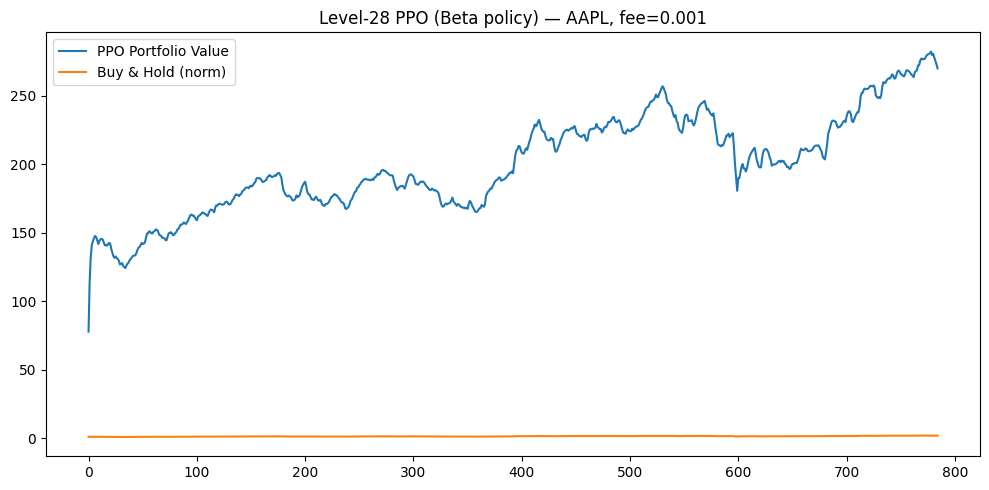

Saved weights and equity to C:\Users\adity\Downloads\Learn_DSA_Quant\Level-28


In [4]:
# Level 28 — PPO for continuous position sizing (Beta policy), one cell (FIXED softplus)

import numpy as np, pandas as pd, yfinance as yf, torch, torch.nn as nn, torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Beta
import matplotlib.pyplot as plt
from pathlib import Path

# ---------------- Config ----------------
TICKER   = "AAPL"
YEARS    = 3
WINDOW   = 15          # lookback length in days
FEE      = 0.001       # proportional fee on turnover |a_t - a_{t-1}|
GAMMA    = 0.99
LAMBDA   = 0.95        # GAE lambda
CLIP_EPS = 0.20
PI_LR    = 3e-4
VF_LR    = 1e-3
EPOCHS   = 25
STEPS_PER_EPOCH = 512  # per rollout
TRAIN_ITERS = 10
VF_COEF  = 0.5
ENT_COEF = 1e-3
REWARD_NORM = True

OUT_DIR = Path(r"C:\Users\adity\Downloads\Learn_DSA_Quant\Level-28")
OUT_DIR.mkdir(parents=True, exist_ok=True)

device = "cuda" if torch.cuda.is_available() else "cpu"

# ---------------- Data (1-D prices) ----------------
def load_prices_1d(ticker, years=3) -> np.ndarray:
    df = yf.download(ticker, period=f"{years}y", interval="1d",
                     auto_adjust=True, progress=False)
    if df is None or df.empty:
        return np.array([], dtype=np.float32)
    col = "Close" if "Close" in df.columns else ("Adj Close" if "Adj Close" in df.columns else df.columns[-1])
    s = df[col].dropna().astype(float)
    s = s[~s.index.duplicated(keep="last")]
    return s.to_numpy(dtype=np.float32).reshape(-1)

def synth_prices(n=1000, seed=28) -> np.ndarray:
    rng = np.random.default_rng(seed)
    r = rng.normal(0.0004, 0.012, n)      # mild drift
    return (100.0 * np.exp(np.cumsum(r))).astype(np.float32)

p = load_prices_1d(TICKER, YEARS)
if p.size == 0:
    print("Using synthetic price series fallback.")
    p = synth_prices(1000, 28)
    TICKER = "SYNTH"

MIN_LEN = max(800, WINDOW + 100)
if p.size < MIN_LEN:
    need = MIN_LEN - p.size
    tail = synth_prices(need, 2801)
    tail = tail / tail[0] * p[-1]
    p = np.concatenate([p, tail]).astype(np.float32)

# ---------------- Environment ----------------
class PositionEnv:
    """
    Continuous action a_t in [0,1] = fraction long.
    State: [(p[t-W:t]/p[t-W])-1, position_{t-1}].
    Reward: ΔPortfolio - fee*turnover, where turnover = |a_t - a_{t-1}|.
    """
    def __init__(self, prices: np.ndarray, window=15, fee=0.001):
        self.p = prices.astype(np.float32).reshape(-1)
        self.n = int(self.p.size)
        self.W = int(window)
        self.fee = float(fee)
        self.reset()

    def reset(self):
        self.t = self.W
        self.pos = 0.0
        self.cash = 1.0
        self.prev_port = 1.0
        return self._state()

    def _state(self):
        w = self.p[self.t - self.W:self.t]
        w0 = float(w[0]) if float(w[0]) != 0.0 else 1.0
        norm = (w / w0) - 1.0
        return np.concatenate([norm.astype(np.float32), np.array([self.pos], dtype=np.float32)])

    def step(self, a):  # a in [0,1]
        a = float(np.clip(a, 0.0, 1.0))
        # pre-trade PV at last price
        port_before = float(self.cash + self.pos * self.p[self.t-1])
        turnover = abs(a - self.pos)
        port_after_fee = port_before * (1.0 - self.fee * turnover)
        self.pos = a
        self.cash = float(port_after_fee * (1.0 - self.pos))

        # move forward one step, value at new last price
        self.t += 1
        done = self.t >= self.n
        portfolio = float(self.cash + self.pos * float(self.p[self.t-1]))
        reward = portfolio - self.prev_port
        self.prev_port = portfolio

        next_state = self._state() if not done else np.zeros(self.W + 1, dtype=np.float32)
        return next_state, float(reward), bool(done), {"portfolio": portfolio}

env = PositionEnv(p, window=WINDOW, fee=FEE)

state_dim = WINDOW + 1
act_dim   = 1  # Beta in [0,1]

# ---------------- Actor-Critic (Beta policy) ----------------
class Actor(nn.Module):
    def __init__(self, sdim):
        super().__init__()
        self.backbone = nn.Sequential(
            nn.Linear(sdim, 64), nn.ReLU(),
            nn.Linear(64, 64), nn.ReLU()
        )
        self.alpha_head = nn.Linear(64, 1)
        self.beta_head  = nn.Linear(64, 1)

    def forward(self, s):
        h = self.backbone(s)
        # alpha, beta > 0; softplus + 1.0 for numerical stability
        alpha = F.softplus(self.alpha_head(h)) + 1.0
        beta  = F.softplus(self.beta_head(h))  + 1.0
        return alpha, beta

    def dist(self, s):
        alpha, beta = self.forward(s)
        return Beta(alpha, beta)

class Critic(nn.Module):
    def __init__(self, sdim):
        super().__init__()
        self.v = nn.Sequential(
            nn.Linear(sdim, 64), nn.ReLU(),
            nn.Linear(64, 64), nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, s):
        return self.v(s).squeeze(-1)

actor = Actor(state_dim).to(device)
critic = Critic(state_dim).to(device)
pi_opt = optim.Adam(actor.parameters(), lr=PI_LR)
vf_opt = optim.Adam(critic.parameters(), lr=VF_LR)

# ---------------- Rollout buffer ----------------
class Buffer:
    def __init__(self, sdim, size, gamma, lam):
        self.s = np.zeros((size, sdim), dtype=np.float32)
        self.a = np.zeros((size, 1), dtype=np.float32)
        self.r = np.zeros(size, dtype=np.float32)
        self.v = np.zeros(size, dtype=np.float32)
        self.logp = np.zeros(size, dtype=np.float32)
        self.done = np.zeros(size, dtype=np.float32)
        self.ptr = 0; self.path_start = 0
        self.gamma, self.lam = gamma, lam

    def store(self, s, a, r, v, logp, done):
        i = self.ptr
        self.s[i] = s
        self.a[i] = a
        self.r[i] = r
        self.v[i] = v
        self.logp[i] = logp
        self.done[i] = done
        self.ptr += 1

    def finish(self, last_val=0.0):
        path_slice = slice(self.path_start, self.ptr)
        rews = np.append(self.r[path_slice], last_val)
        vals = np.append(self.v[path_slice], last_val)
        deltas = rews[:-1] + self.gamma * vals[1:] - vals[:-1]
        adv = np.zeros_like(deltas, dtype=np.float32)
        gae = 0.0
        for t in reversed(range(len(deltas))):
            gae = deltas[t] + self.gamma * self.lam * gae
            adv[t] = gae
        ret = adv + vals[:-1]
        self.adv = adv
        self.ret = ret
        self.path_start = self.ptr

    def get(self):
        assert self.ptr == len(self.s)
        adv = self.adv
        if REWARD_NORM:
            adv = (adv - adv.mean()) / (adv.std() + 1e-8)
        return {
            "s":    torch.tensor(self.s,   dtype=torch.float32, device=device),
            "a":    torch.tensor(self.a,   dtype=torch.float32, device=device),
            "ret":  torch.tensor(self.ret, dtype=torch.float32, device=device),
            "adv":  torch.tensor(adv,      dtype=torch.float32, device=device),
            "logp": torch.tensor(self.logp,dtype=torch.float32, device=device),
        }

# ---------------- PPO core ----------------
def ppo_update(data):
    s,a,ret,adv,logp_old = data["s"], data["a"], data["ret"], data["adv"], data["logp"]
    for _ in range(TRAIN_ITERS):
        dist = actor.dist(s)
        # clamp to [0,1] to match Beta support numerically
        logp = dist.log_prob(a.clamp(0,1)).sum(-1)
        ratio = torch.exp(logp - logp_old)
        clipped = torch.clamp(ratio, 1.0 - CLIP_EPS, 1.0 + CLIP_EPS) * adv
        loss_pi = -(torch.min(ratio * adv, clipped)).mean() - ENT_COEF * dist.entropy().mean()

        v = critic(s)
        loss_v = ((v - ret)**2).mean() * VF_COEF

        pi_opt.zero_grad(); loss_pi.backward(); pi_opt.step()
        vf_opt.zero_grad(); loss_v.backward(); vf_opt.step()

    return float(loss_pi.item()), float(loss_v.item())

def rollout(env, steps):
    buf = Buffer(state_dim, steps, GAMMA, LAMBDA)
    s = env.reset()
    for t in range(steps):
        st = torch.tensor(s, dtype=torch.float32, device=device).unsqueeze(0)
        with torch.no_grad():
            dist = actor.dist(st)
            a = dist.sample().squeeze(0)            # shape [1] -> []
            logp = dist.log_prob(a).sum(-1)         # scalar
            v = critic(st).squeeze(0)               # scalar
        a_np = float(a.clamp(0,1).cpu().item())
        ns, r, d, info = env.step(a_np)
        buf.store(s, a_np, r, float(v.cpu().item()), float(logp.cpu().item()), float(d))
        s = ns
        if d:
            buf.finish(0.0)  # terminal bootstrap = 0
            s = env.reset()
    # bootstrap if final path didn't end
    st = torch.tensor(s, dtype=torch.float32, device=device).unsqueeze(0)
    with torch.no_grad():
        last_v = float(critic(st).cpu().item())
    buf.finish(last_v)
    return buf.get()

# ---------------- Train ----------------
episode_eval_pv = []
for ep in range(1, EPOCHS + 1):
    data = rollout(env, STEPS_PER_EPOCH)
    lpi, lvf = ppo_update(data)

    # quick eval using mean action
    s = env.reset(); eq = []
    while True:
        st = torch.tensor(s, dtype=torch.float32, device=device).unsqueeze(0)
        with torch.no_grad():
            a = actor.dist(st).mean.squeeze(0)
        a_np = float(a.clamp(0,1).cpu().item())
        ns, r, d, info = env.step(a_np)
        eq.append(float(info["portfolio"]))
        s = ns
        if d: break
    episode_eval_pv.append(eq[-1])
    print(f"Epoch {ep:02d} | π:{lpi:.4f}  V:{lvf:.4f}  EvalPV:{eq[-1]:.4f}")

# Save models
torch.save(actor.state_dict(), OUT_DIR / f"{TICKER}_ppo_actor.pth")
torch.save(critic.state_dict(), OUT_DIR / f"{TICKER}_ppo_critic.pth")

# ---------------- Final evaluation & plot ----------------
s = env.reset(); eq=[]
while True:
    st = torch.tensor(s, dtype=torch.float32, device=device).unsqueeze(0)
    with torch.no_grad():
        a = actor.dist(st).mean.squeeze(0)
    a_np = float(a.clamp(0,1).cpu().item())
    ns, r, d, info = env.step(a_np)
    eq.append(float(info["portfolio"]))
    s = ns
    if d: break

eq = np.array(eq, dtype=float)
bh = p[-len(eq):] / float(p[-len(eq)])

eq_df = pd.DataFrame({"step": np.arange(len(eq)), "ppo_portfolio": eq, "bh_norm": bh})
eq_df.to_csv(OUT_DIR / f"{TICKER}_ppo_equity.csv", index=False)

plt.figure(figsize=(10,5))
plt.plot(eq, label="PPO Portfolio Value")
plt.plot(bh, label="Buy & Hold (norm)")
plt.title(f"Level-28 PPO (Beta policy) — {TICKER}, fee={FEE}")
plt.legend(); plt.tight_layout(); plt.show()

print(f"Saved weights and equity to {OUT_DIR}")
